# CLASSIFIER

## IMPORTS

In [1]:
import matplotlib.pyplot as plt
import torch
import torchvision
from torchvision import datasets
import os
from glob import glob
import pandas as pd
from tqdm import tqdm
import shutil
from sklearn.model_selection import GroupKFold
from torch.nn.modules.loss import BCEWithLogitsLoss
from torch.optim import lr_scheduler
import numpy as np
from PIL import Image
import seaborn as sns
import math

## CONFIG

#### Project Config:

- root_dir :
    - train.csv
    - kaggle.json

In [2]:
ROOT_DIR = '/kaggle/'  # '/content/' if Google Colab, '/kaggle/' if Kaggle
TRAIN_DIR = ROOT_DIR + 'data/train/'
TEST_DIR = ROOT_DIR + 'data/test/'
TRAIN_CSV = ROOT_DIR + 'train.csv'
TRAIN_META_CSV = ROOT_DIR + 'train_meta.csv'
TEST_CSV = ROOT_DIR + 'test.csv'
CLASSIFIER = ROOT_DIR + 'classifier/'
CLASSIFIER_TRAIN = CLASSIFIER + 'train/'
CLASSIFIER_VAL = CLASSIFIER + 'val/'

device = "cuda" if torch.cuda.is_available() else "cpu"

## /!\ TO TRIGGER IF RUNNING ON KAGGLE ONLY /!\

In [3]:
def is_kaggle():
    """
    If the code is running on Kaggle take custom data from private repo and copy to root directory
    /!\ On Kaggle I have a private dataset (data-ai) containing: /!\
    - train.csv
    - test.csv
    - train_meta.csv
    - kaggle.json
    You can use your own data or download from Kaggle, just change the paths
    """
    os.chdir('..')
    !cp input/data-ai/kaggle.json .
    !cp input/data-ai/test.csv .
    !cp input/data-ai/train.csv .
    !cp input/data-ai/train_meta.csv .
    !pwd
    !ls

is_kaggle()

/kaggle
input  kaggle.json  lib  test.csv  train.csv  train_meta.csv  working


## FUNCTIONS

#### DONWLOAD DATA

In [4]:
def download_data(image_size=512):
    """
    Download data from Kaggle
    :param image_size: 256, 512 or 1024
    :return: None
    """
    !pip install -q kaggle
    !mkdir -p ~/.kaggle
    !cp kaggle.json ~/.kaggle/
    !chmod 600 ~/.kaggle/kaggle.json
    if image_size == 256:
        !kaggle datasets download -d xhlulu/vinbigdata-chest-xray-resized-png-256x256
        !unzip vinbigdata-chest-xray-resized-png-256x256.zip -d data
    elif image_size == 512:
        !kaggle datasets download -d xhlulu/vinbigdata
        !unzip vinbigdata.zip -d data
    elif image_size == 1024:
        !kaggle datasets download -d xhlulu/vinbigdata-chest-xray-resized-png-1024x1024
        !unzip vinbigdata-chest-xray-resized-png-1024x1024.zip -d data
    else:
        print("Image size not supported")

    print(f"Number of train files: {len(glob(TRAIN_DIR + '*.png'))}")
    print(f"Number of test files: {len(glob(TEST_DIR + '*.png'))}")

#### DIRECTORIES

In [5]:
def create_directories():
    """
    Create directories for the project
    :return: None
    """
    os.mkdir('classifier')
    os.chdir('classifier')
    os.mkdir('train')
    os.mkdir('val')
    os.chdir('train')
    os.mkdir('finding')
    os.mkdir('no_finding')
    os.chdir('../val')
    os.mkdir('finding')
    os.mkdir('no_finding')
    os.chdir('..')
    os.chdir('..')

#### DATA PREPARATION

In [6]:
def add_image_path(df_train):
    """
    Add image path to train dataframe
    :param df_train: Dataframe with train data
    :return: None
    """
    df_train['image_path'] = TRAIN_DIR + df_train.image_id + '.png'

In [7]:
def get_fold_split(df_train, n_splits=6):
    """
    Split train data into train and validation sets
    :param df_train: Dataframe with train data
    :param n_splits: Number of splits
    :return: train_files, val_files
    """
    gkf = GroupKFold(n_splits=n_splits)
    df_train['fold'] = -1
    for fold, (train_idx, val_idx) in enumerate(gkf.split(df_train, groups=df_train.image_id.tolist())):
        df_train.loc[val_idx, 'fold'] = fold
    train_files = []
    val_files = []
    val_files += list(df_train[df_train.fold == fold].image_path.unique())
    train_files += list(df_train[df_train.fold != fold].image_path.unique())
    print(f"Train: {len(train_files)} - Val: {len(val_files)}")
    return train_files, val_files

In [8]:
def copy_files(df_train):
    """
    Copy files to train and validation directories
    :param df_train: Dataframe with train data
    :param classifier_train: Path to train directory
    :param classifier_val: Path to validation directory
    :return: None
    """
    for i, row in tqdm(df_train.iterrows(), total=len(df_train)):
        if row.fold == 1:
            if row['class_id'] == 14:
                shutil.copyfile(row.image_path, CLASSIFIER_VAL + 'no_finding/' + row.image_id + '.png')
            else:
                shutil.copyfile(row.image_path, CLASSIFIER_VAL + 'finding/' + row.image_id + '.png')
        else:
            if row['class_id'] == 14:
                shutil.copyfile(row.image_path, CLASSIFIER_TRAIN + 'no_finding/' + row.image_id + '.png')
            else:
                shutil.copyfile(row.image_path, CLASSIFIER_TRAIN + 'finding/' + row.image_id + '.png')
    print(f"Train No Finding: {len([f for f in os.listdir(CLASSIFIER_TRAIN + 'no_finding/')])}")
    print(f"Train Finding: {len([f for f in os.listdir(CLASSIFIER_TRAIN + 'finding/')])}")
    print(f"Val No Finding: {len([f for f in os.listdir(CLASSIFIER_VAL + 'no_finding/')])}")
    print(f"Val Finding: {len([f for f in os.listdir(CLASSIFIER_VAL + 'finding/')])}")

In [9]:
def data_preparation():
    """
    Prepare data for training
    :return: None
    """
    create_directories()
    df_train = pd.read_csv(TRAIN_CSV)
    df_meta = pd.read_csv(TRAIN_META_CSV)
    add_image_path(df_train)
    train_files, val_files = get_fold_split(df_train)
    print('Copy files...')
    copy_files(df_train)

#### DATA AUGMENTATION

In [10]:
def get_transformers():
    """
    Get transformers for train and validation sets
    :return: train_transforms, val_transforms, test_transforms
    """
    train_transforms = torchvision.transforms.Compose([
        torchvision.transforms.Resize(256),
        # torchvision.transforms.RandomHorizontalFlip(p=0.5),
        # torchvision.transforms.RandomVerticalFlip(p=0.5),
        # torchvision.transforms.RandomRotation(10),
        # torchvision.transforms.RandomApply([torchvision.transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1)], p=0.5),
        # torchvision.transforms.RandomApply([torchvision.transforms.GaussianBlur(3, sigma=(0.1, 2.0))], p=0.5),
        # torchvision.transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
        torchvision.transforms.RandomAffine(degrees=10, translate=(0, 0.1), scale=(1, 1.10)),
        torchvision.transforms.CenterCrop(224),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    val_transforms = torchvision.transforms.Compose([
        torchvision.transforms.Resize(256),
        torchvision.transforms.CenterCrop(224),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    test_transforms = torchvision.transforms.Compose([
        torchvision.transforms.Resize(256),
        torchvision.transforms.CenterCrop(224),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ])
    return train_transforms, val_transforms, test_transforms

In [11]:
def get_dataloaders(batch_size=16):
    """
    Get dataloaders for train and validation sets
    :return: train_dataloader, val_dataloader
    """
    train_transforms, val_transforms, _ = get_transformers()

    train_dataset = datasets.ImageFolder(root=CLASSIFIER_TRAIN, transform=train_transforms)
    val_dataset = datasets.ImageFolder(root=CLASSIFIER_VAL, transform=val_transforms)

    train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2,
                                                   pin_memory=True)
    val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2,
                                                 pin_memory=True)
    print(f"Train: {len(train_dataset)} - Val: {len(val_dataset)}")
    print('Idx to class:', train_dataset.class_to_idx)

    return train_dataloader, val_dataloader

#### MODEL

In [12]:
def get_model(model_='EfficientNet_B7'):
    """
    Download model and replace last layer
    :return: model
    """
    if model_=='EfficientNet_B7':
        model = torchvision.models.efficientnet_b7(weights=torchvision.models.EfficientNet_B7_Weights)
        last_layer = list(model.children())[-1] # Get the last layer of the model
        last_layer_layer = list(last_layer.children())[-1] # Get the sub-layer of the last layer
        num_features = last_layer_layer.in_features # Get the number of input features for the sub-layer
        last_layer[-1] = torch.nn.Linear(num_features, 1) # Replace the sub-layer with a linear layer with 1 output
        # print(model) # Print the updated model architecture
    elif model_=='EfficientNet_B6':
        model = torchvision.models.efficientnet_b6(weights=torchvision.models.EfficientNet_B6_Weights)
        last_layer = list(model.children())[-1] # Get the last layer of the model
        last_layer_layer = list(last_layer.children())[-1] # Get the sub-layer of the last layer
        num_features = last_layer_layer.in_features # Get the number of input features for the sub-layer
        last_layer[-1] = torch.nn.Linear(num_features, 1) # Replace the sub-layer with a linear layer with 1 output
        # print(model) # Print the updated model architecture
    elif model_=='EfficientNet_B5':
        model = torchvision.models.efficientnet_b5(weights=torchvision.models.EfficientNet_B5_Weights)
        last_layer = list(model.children())[-1] # Get the last layer of the model
        last_layer_layer = list(last_layer.children())[-1] # Get the sub-layer of the last layer
        num_features = last_layer_layer.in_features # Get the number of input features for the sub-layer
        last_layer[-1] = torch.nn.Linear(num_features, 1) # Replace the sub-layer with a linear layer with 1 output
        # print(model) # Print the updated model architecture
    elif model_=='EfficientNet_B4':
        model = torchvision.models.efficientnet_b4(weights=torchvision.models.EfficientNet_B4_Weights)
        last_layer = list(model.children())[-1] # Get the last layer of the model
        last_layer_layer = list(last_layer.children())[-1] # Get the sub-layer of the last layer
        num_features = last_layer_layer.in_features # Get the number of input features for the sub-layer
        last_layer[-1] = torch.nn.Linear(num_features, 1) # Replace the sub-layer with a linear layer with 1 output
        # print(model) # Print the updated model architecture
    elif model_=='EfficientNet_B3':
        model = torchvision.models.efficientnet_b3(weights=torchvision.models.EfficientNet_B3_Weights)
        last_layer = list(model.children())[-1] # Get the last layer of the model
        last_layer_layer = list(last_layer.children())[-1] # Get the sub-layer of the last layer
        num_features = last_layer_layer.in_features
        last_layer[-1] = torch.nn.Linear(num_features, 1)
    elif model_=='resnet18':
        model = torchvision.models.resnet18(weights=torchvision.models.ResNet18_Weights)
        num_ftrs = model.fc.in_features
        model.fc = torch.nn.Linear(num_ftrs, 1)
    elif model_=='resnet50':
        model = torchvision.models.resnet50(weights=torchvision.models.ResNet50_Weights)
        num_ftrs = model.fc.in_features
        model.fc = torch.nn.Linear(num_ftrs, 1)
    elif model_=='resnet101':
        model = torchvision.models.resnet101(weights=torchvision.models.ResNet101_Weights)
        num_ftrs = model.fc.in_features
        model.fc = torch.nn.Linear(num_ftrs, 1)
    elif model_=='resnet152':
        model = torchvision.models.resnet152(weights=torchvision.models.ResNet152_Weights)
        num_ftrs = model.fc.in_features
        model.fc = torch.nn.Linear(num_ftrs, 1)
    elif model_=='densenet121':
        model = torchvision.models.densenet121(weights=torchvision.models.DenseNet121_Weights)
        num_ftrs = model.classifier.in_features
        model.classifier = torch.nn.Linear(num_ftrs, 1)
    elif model_=='densenet169':
        model = torchvision.models.densenet169(weights=torchvision.models.DenseNet169_Weights)
        num_ftrs = model.classifier.in_features
        model.classifier = torch.nn.Linear(num_ftrs, 1)
    elif model_=='densenet201':
        model = torchvision.models.densenet201(weights=torchvision.models.DenseNet201_Weights)
        num_ftrs = model.classifier.in_features
        model.classifier = torch.nn.Linear(num_ftrs, 1)
    else:
        raise ValueError('Model not found, please choose one of the following: EfficientNet_B7, EfficientNet_B6, EfficientNet_B5, EfficientNet_B4, EfficientNet_B3, resnet18, resnet50, resnet101, resnet152, densenet121, densenet169, densenet201')

    if torch.cuda.device_count() > 1: # check if multiple GPUs are available
        print("Let's use", torch.cuda.device_count(), "GPUs!")
        model = torch.nn.DataParallel(model) # make parallel
    model = model.to(device)
    return model

In [13]:
def make_train_step(model, optimizer, loss_fn):
    """
    Builds function that performs a step in the train loop
    :param model: model
    :param optimizer: optimizer
    :param loss_fn: loss function
    :return: train_step
    """
    def train_step(x, y):
        """
        Performs a train step
        :param x: input
        :param y: target
        :return: loss
        """
        yhat = model(x)  # Make prediction
        model.train()  #enter train mode
        loss = loss_fn(yhat, y)  #compute loss
        loss.backward()  # backpropagation
        optimizer.step()  #update weights
        optimizer.zero_grad()  #zero gradients

        return loss.item()

    return train_step

In [14]:
def get_train_step(model):
    """
    Get train step
    :param model: model
    :return: train_step
    """

    loss_fn = BCEWithLogitsLoss()  #binary cross entropy with sigmoid, so no need to use sigmoid in the model
    optimizer = torch.optim.Adam(model.parameters())
    scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
    train_step = make_train_step(model, optimizer, loss_fn)

    return train_step

#### TRAINING

In [15]:
def save_weights(model, filename='best_weight.pt'):
    """
    Save model weights
    :param model: model
    :return: None
    """
    color = "\033[0;92m" if filename == 'best_weight.pt' else "\033[0;93m"
    torch.save(model.state_dict(), ROOT_DIR + filename)
    print(color+'Model weights saved at {}'.format(ROOT_DIR + filename))

In [16]:
def train(model, batch=16, n_epochs=15, early_stopping_tolerance=3,
          early_stopping_threshold=0.01):
    """
    Train model
    :param model: model
    :param batch: batch size
    :param n_epochs: number of epochs
    :param early_stopping_tolerance: early stopping tolerance
    :param early_stopping_threshold: early stopping threshold
    :return:None
    """
    train_step = get_train_step(model)
    train_dataloader, val_dataloader = get_dataloaders(batch_size=batch)

    loss_fn = BCEWithLogitsLoss()
    losses = []
    val_losses = []

    epoch_train_losses = []
    epoch_test_losses = []
    early_stopping_counter = 0

    for epoch in range(n_epochs):
        epoch_loss = 0
        for i, data in tqdm(enumerate(train_dataloader), total=len(train_dataloader)):  #iterate ove batches
            x_batch, y_batch = data
            x_batch = x_batch.to(device)  #move to gpu
            y_batch = y_batch.unsqueeze(1).float()  #convert target to same nn output shape
            y_batch = y_batch.to(device)  #move to gpu

            loss = train_step(x_batch, y_batch)
            epoch_loss += loss / len(train_dataloader)
            losses.append(loss)

        epoch_train_losses.append(epoch_loss)
        print('\nEpoch : {}, train loss : {}'.format(epoch + 1, epoch_loss))

        #validation doesnt requires gradient
        with torch.no_grad():
            cum_loss = 0
            total = 0
            correct = 0
            for x_batch, y_batch in tqdm(val_dataloader, total=len(val_dataloader)):
                x_batch = x_batch.to(device)
                y_batch = y_batch.unsqueeze(1).float()  #convert target to same nn output shape
                y_batch = y_batch.to(device)

                #model to eval mode
                model.eval()

                yhat = model(x_batch)
                val_loss = loss_fn(yhat, y_batch).item()
                cum_loss += val_loss / len(val_dataloader)
                val_losses.append(val_loss)

                predicted = torch.round(torch.sigmoid(yhat))
                total += y_batch.size(0)
                correct += (predicted == y_batch).sum().item()

            epoch_test_losses.append(cum_loss)
            print('Epoch : {}, val loss : {}'.format(epoch + 1, cum_loss))
            print('Accuracy of the model on the validation set: %.2f%%' % (100 * correct / total))

            best_loss = min(epoch_test_losses)

            #save best model
            if cum_loss <= best_loss:
                best_model_wts = model.state_dict()
                save_weights(model)
            else:
                save_weights(model, filename='last_weight.pt')

            if cum_loss > best_loss:
                early_stopping_counter +=1 # add counter
            else:
                early_stopping_counter = 0 # reset counter

            if (early_stopping_counter >= early_stopping_tolerance) or (best_loss <= early_stopping_threshold):
                print("/nTerminating: early stopping")
                break  #terminate training

    model.load_state_dict(torch.load(ROOT_DIR+"best_weight.pt"))
    print(f'Finished Training, best loss : {best_loss}, best weights loaded in model')

#### TESTING

In [17]:
def check_val(model):
    """
    Check validation loss and accuracy after training
    :param model: model
    :param val_dataloader: validation dataloader
    :return: None
    """
    # create confusion matrix
    FP = 0
    FN = 0
    TP = 0
    TN = 0

    _, val_dataloader = get_dataloaders()
    loss_fn = BCEWithLogitsLoss()
    with torch.no_grad():
        cum_loss = 0
        total = 0
        correct = 0
        for x_batch, y_batch in tqdm(val_dataloader, total=len(val_dataloader)):
            x_batch = x_batch.to(device)
            y_batch = y_batch.unsqueeze(1).float()  #convert target to same nn output shape
            y_batch = y_batch.to(device)

            #model to eval mode
            model.eval()

            yhat = model(x_batch)
            val_loss = loss_fn(yhat, y_batch).item()
            cum_loss += val_loss / len(val_dataloader)

            # confusion matrix
            predicted = torch.round(torch.sigmoid(yhat))

            for i in range(len(predicted)):
                if predicted[i] == 1 and y_batch[i] == 0:
                    FP += 1
                elif predicted[i] == 0 and y_batch[i] == 1:
                    FN += 1
                elif predicted[i] == 1 and y_batch[i] == 1:
                    TP += 1
                elif predicted[i] == 0 and y_batch[i] == 0:
                    TN += 1

            total += y_batch.size(0)
            correct += (predicted == y_batch).sum().item()

        print('Accuracy of the model on the validation set: %.2f%%' % (100 * correct / total))
        print('Loss of the model on the validation set: %.2f' % (cum_loss))
        print('Confusion matrix: \n', 'TP: ', TP, 'FP: ', FP, 'FN: ', FN, 'TN: ', TN)
        print('Precision: ', TP/(TP+FP))
        print('Recall: ', TP/(TP+FN))
        print('F1 score: ', 2*TP/(2*TP+FP+FN))
        print('Specificity: ', TN/(TN+FP))
        print('Accuracy: ', (TP+TN)/(TP+TN+FP+FN))
        print('MCC: ', (TP*TN-FP*FN)/math.sqrt((TP+FP)*(TP+FN)*(TN+FP)*(TN+FN)))
        print('FPR: ', FP/(FP+TN))
        cm = np.array([[TP, FP], [FN, TN]])
        plt.figure(figsize=(5,5))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.title('Confusion matrix')
        plt.ylabel('Actual label')
        plt.xlabel('Predicted label')
        plt.show()


In [18]:
def predict(model, filename_='classifier.csv'):
    """
    Predict test data
    :param model: model
    :return: None
    """
    _, _, test_transforms = get_transformers()
    model.eval()
    results = []

    for filename in tqdm(os.listdir(TEST_DIR)):
        img = Image.open(os.path.join(TEST_DIR, filename)).convert('RGB')
        img = test_transforms(img)
        img = img.unsqueeze(0).to(device)

        with torch.no_grad():
            output = model(img)
            predicted = torch.round(torch.sigmoid(output))
            confidence = torch.sigmoid(output)
            results.append((filename.split('.')[0], confidence.item()))

    pred_classifier = pd.DataFrame(results, columns=['image_id', 'target'])
    pred_classifier.to_csv(filename_, index=False)
    display(pred_classifier.head())
    print('Predictions saved at {}'.format(ROOT_DIR + filename_))

## RUN

#### DOWNLOAD DATA

In [19]:
download_data(image_size=256)

 99%|████████████████████████████████████████▍| 542M/550M [00:04<00:00, 141MB/s]
100%|█████████████████████████████████████████| 550M/550M [00:04<00:00, 122MB/s]
Archive:  vinbigdata-chest-xray-resized-png-256x256.zip
  inflating: data/test/002a34c58c5b758217ed1f584ccbcfe9.png  
  inflating: data/test/004f33259ee4aef671c2b95d54e4be68.png  
  inflating: data/test/008bdde2af2462e86fd373a445d0f4cd.png  
  inflating: data/test/009bc039326338823ca3aa84381f17f1.png  
  inflating: data/test/00a2145de1886cb9eb88869c85d74080.png  
  inflating: data/test/00b7e6bfa4dc1fe9ddd0ce74743e38c2.png  
  inflating: data/test/011295e0bcdc7636569ab73bfdcc4450.png  
  inflating: data/test/013c169f9dad6f1f6485da961b9f7bf2.png  
  inflating: data/test/01431a2618c0ace741e4e270a37e20b9.png  
  inflating: data/test/0168eb925aa6f28a78b16134792f5d0e.png  
  inflating: data/test/016bc723c3ceedb78e27ebfe7032498e.png  
  inflating: data/test/0171021638f9272a34a41feb84ed47a0.png  
  inflating: data/test/019df578e38053e

#### PREPROCESS DATA

In [20]:
data_preparation()

Train: 12500 - Val: 2500
Copy files...


100%|██████████| 67914/67914 [00:33<00:00, 2028.93it/s]

Train No Finding: 8836
Train Finding: 3664
Val No Finding: 1770
Val Finding: 730


#### MODEL

In [21]:
model = get_model("EfficientNet_B4")

/opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B4_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B4_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b4_rwightman-7eb33cd5.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b4_rwightman-7eb33cd5.pth


  0%|          | 0.00/74.5M [00:00<?, ?B/s]

Let's use 2 GPUs!


#### TRAIN

In [22]:
train(model, batch=16, n_epochs=5, early_stopping_tolerance=3, early_stopping_threshold=0.03)

Train: 12500 - Val: 2500
Idx to class: {'finding': 0, 'no_finding': 1}


100%|██████████| 782/782 [03:51<00:00,  3.38it/s]



Epoch : 1, train loss : 0.31021870846581445


100%|██████████| 157/157 [00:20<00:00,  7.54it/s]


Epoch : 1, val loss : 0.20689308403688622
Accuracy of the model on the validation set: 91.56%
Model weights saved at /kaggle/best_weight.pt


100%|██████████| 782/782 [03:38<00:00,  3.58it/s]



Epoch : 2, train loss : 0.21166268607977853


100%|██████████| 157/157 [00:21<00:00,  7.33it/s]


Epoch : 2, val loss : 0.17347936882714554
Accuracy of the model on the validation set: 92.96%
Model weights saved at /kaggle/best_weight.pt


100%|██████████| 782/782 [03:37<00:00,  3.59it/s]



Epoch : 3, train loss : 0.17748933390873814


100%|██████████| 157/157 [00:21<00:00,  7.47it/s]


Epoch : 3, val loss : 0.1377970537624565
Accuracy of the model on the validation set: 94.80%
Model weights saved at /kaggle/best_weight.pt


100%|██████████| 782/782 [03:37<00:00,  3.60it/s]



Epoch : 4, train loss : 0.15077971814729083


100%|██████████| 157/157 [00:21<00:00,  7.44it/s]


Epoch : 4, val loss : 0.16116000743654021
Accuracy of the model on the validation set: 93.96%
Model weights saved at /kaggle/last_weight.pt


100%|██████████| 782/782 [03:36<00:00,  3.61it/s]



Epoch : 5, train loss : 0.14062116886078205


100%|██████████| 157/157 [00:21<00:00,  7.36it/s]


Epoch : 5, val loss : 0.13884319970235937
Accuracy of the model on the validation set: 94.88%
Model weights saved at /kaggle/last_weight.pt
Finished Training, best loss : 0.1377970537624565, best weights loaded in model


#### CHECK VAL

Train: 12500 - Val: 2500
Idx to class: {'finding': 0, 'no_finding': 1}


100%|██████████| 157/157 [00:21<00:00,  7.46it/s]


Accuracy of the model on the validation set: 94.80%
Loss of the model on the validation set: 0.14
Confusion matrix: 
 TP:  1742 FP:  102 FN:  28 TN:  628
Precision:  0.9446854663774403
Recall:  0.984180790960452
F1 score:  0.9640287769784173
Specificity:  0.8602739726027397
Accuracy:  0.948
MCC:  0.8727544564581439
FPR:  0.13972602739726028


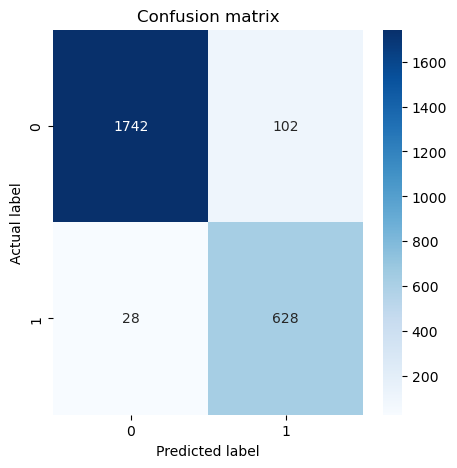

In [23]:
check_val(model)

#### PREDICT

In [24]:
predict(model)

100%|██████████| 3000/3000 [03:00<00:00, 16.58it/s]


,image_id,target
0,c9fbdd6dbbd3e5246b0184824f681e0f,0.860541
1,b12232ebf575db0226671621146f76e1,0.999992
2,e713fe6ed28f23aed83f54c56ff30189,0.999979
3,754b90e60a89d03d18dbf9b30cce6eec,0.999465
4,d7494cea30e4fa1e4b4ebd0ecc6e03e5,0.692806


Predictions saved at /kaggle/classifier.csv


## FINE TUNING

#### FINE TUNING LOOP THROUGH MODELS

In [ ]:
check_val(model)
predict(model, filename_=f"working/EfficientNet_B6.csv")

In [ ]:
models = ["EfficientNet_B5", "EfficientNet_B4", "EfficientNet_B3", "resnet18", "resnet50", "resnet101", "resnet152", "densenet121", "densenet169", "densenet201"]
for model_ in models:
    print(f"Training {model_}")
    model = get_model(model_)
    train(model, batch=16, n_epochs=10, early_stopping_tolerance=3, early_stopping_threshold=0.01)
    check_val(model)
    predict(model, filename_=f"working/{model_}.csv")
    print(f"Finished training {model_}")
    print("")

#### FINE TUNING LOOP THROUGH BATCH SIZE

In [ ]:
for batch in [8, 16, 32, 64]:
    print(f"Training with batch size {batch}")
    model = get_model()
    train(model, batch=batch, n_epochs=10, early_stopping_tolerance=3, early_stopping_threshold=0.01)
    check_val(model)
    predict(model, filename=f"batch_{batch}.csv")
    print(f"Finished training with batch size {batch}")
    print("")

#### FINE TUNING LOOP THROUGH EPOCHS

In [ ]:
for n_epochs in [5, 10, 15, 20]:
    print(f"Training with {n_epochs} epochs")
    model = get_model()
    train(model, batch=16, n_epochs=n_epochs, early_stopping_tolerance=3, early_stopping_threshold=0.01)
    check_val(model)
    predict(model, filename=f"epochs_{n_epochs}.csv")
    print(f"Finished training with {n_epochs} epochs")
    print("")